In [2]:
import pygplates
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../../passive_margins')
sys.path.append('../../atom_utils')
sys.path.append('../../GPlatesClassStruggle')

from pigplates import sphere_tools as pigsph
from reconstruct_atom_rasters import *

#import PlateFrameRasters

%matplotlib inline
%load_ext autoreload
%autoreload 2

#from Package_ReconstructScalarCoverages import group_points_by_plate_id, reconstruct_point_groups

from raster_reconstruction_classes import *
from reconstruction_classes import *

rotation_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_2012.1.rot'
static_polygon_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_ContinentalPolygons_2012.1.gpmlz'

S2012 = ReconstructionModel('Seton++2012')
S2012.add_rotation_model(rotation_filename)
S2012.add_static_polygons(static_polygon_filename)


paleotopography_grid = '../published/Herold/herold_etal_eocene_topo_1x1.nc'

ptopo = GplatesRaster(paleotopography_grid, z_field_name='topo')

#static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)
#rotation_model = pygplates.RotationModel(rotation_filename)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


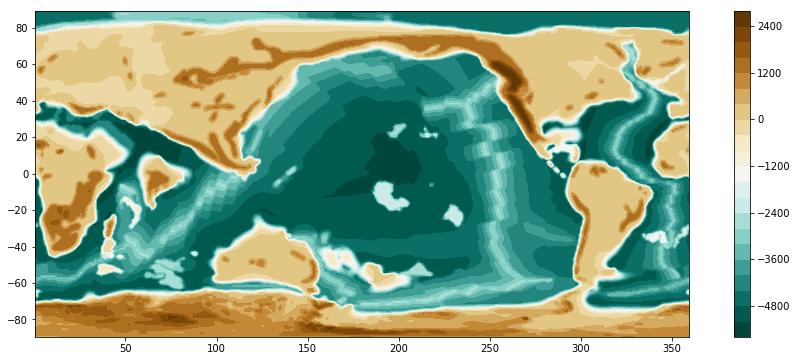

In [6]:
ptopo.plot()


Reconstruct static polygons...
Find static polygons...
Group by polygons...
Reverse reconstruct points...
Sample present-day grid...


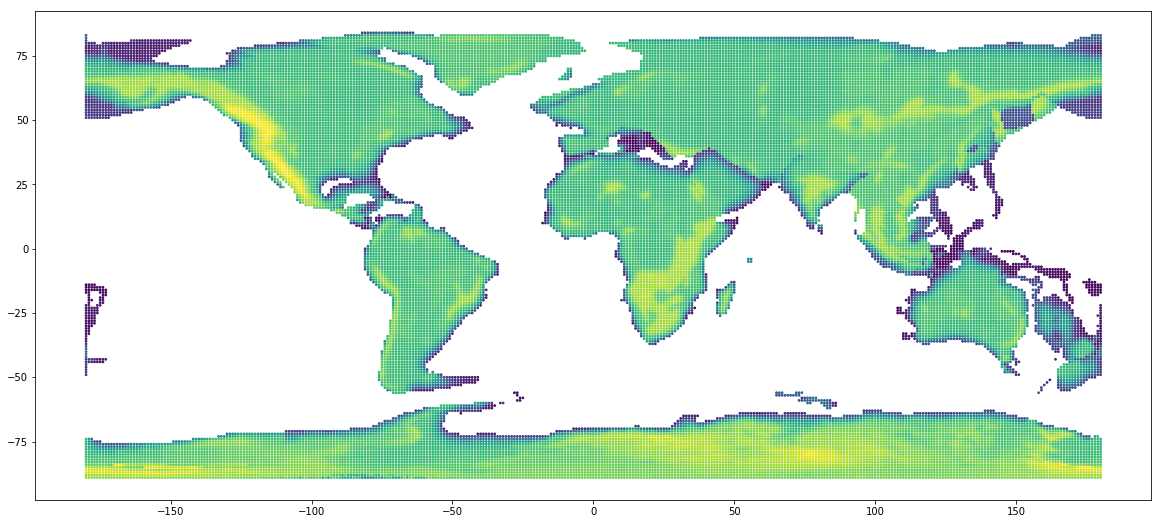

In [14]:
from_time = 55.
to_time = 0.

(unreconstructed_point_lons,
 unreconstructed_point_lats,
 eocene_topography_points) = reconstruct_raster(ptopo, S2012, 
                                                from_time, to_time, 
                                                grid_sampling=1.0)

plt.figure(figsize=(20,9))
plt.scatter(unreconstructed_point_lons,unreconstructed_point_lats,
            c=eocene_topography_points,s=3)
plt.show()


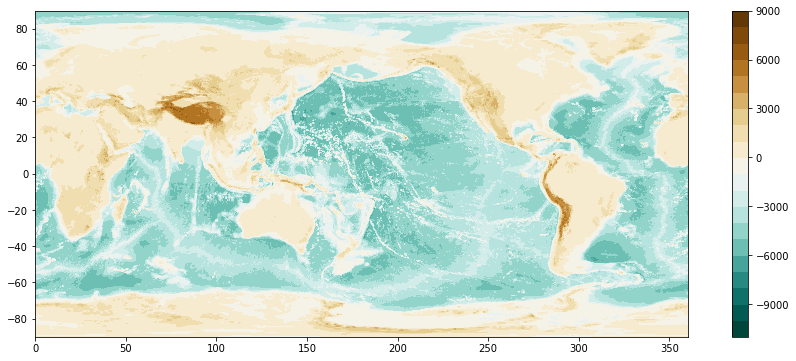

In [19]:
topography = GplatesRaster('../data/ETOPO1_0.1.grd')

topography.plot()


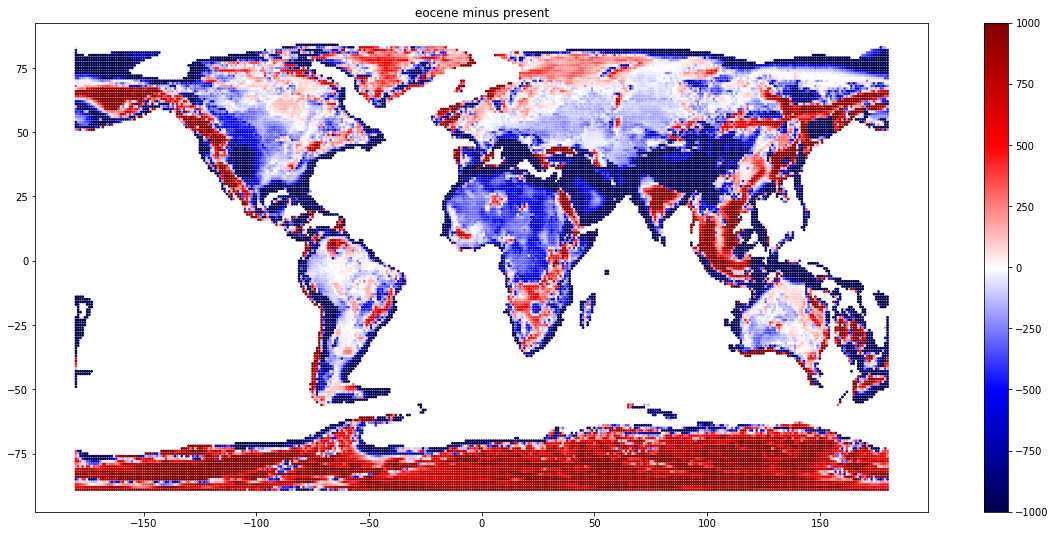

In [18]:
present_day_topography_points = topography.sample_using_gmt(unreconstructed_point_lons,
                                                            unreconstructed_point_lats)

plt.figure(figsize=(20,9))
plt.scatter(unreconstructed_point_lons, unreconstructed_point_lats,
            c=eocene_topography_points-present_day_topography_points, s=3,
            cmap=plt.cm.seismic, vmin=-1000., vmax=1000.)
plt.colorbar()
plt.title('eocene minus present')
plt.show()